In [40]:
from xgboost import XGBClassifier
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import json

malware_json_file = "recognizerAI/modelsDataset/benign_summary_v20.json"
benign_json_file = "recognizerAI/modelsDataset/malware_summary_v20.json"
malware_json = None
benign_json = None
MODEL_FILENAME="model_random_forest_classifier.joblib"

with open(malware_json_file, 'r') as file:
    malware_json = json.load(file)

with open(benign_json_file, 'r') as file:
    benign_json = json.load(file)

In [25]:
import numpy as np
from itertools import chain

dataset = []
for element in chain(malware_json, benign_json):
    session = element["session_chunk"]
    server_port = int(session["port_dst"])
    bytes_client_server = session["bytes_sent_client_server"] 
    bytes_server_client = session["bytes_sent_server_client"] 
    session_time = session["session_time"]
    session_type = 0
    addr_in_DNS = 0
    if session["class"] == "malware":
        session_type = 1
    if session["ip_addr_in_DNS"]:
        addr_in_DNS = 1
    dataset.append([server_port,bytes_client_server, bytes_server_client, session_time, addr_in_DNS, session_type])
    # dataset.append([bytes_client_server, bytes_server_client, session_time, addr_in_DNS, session_type])

dataset = np.array(dataset)


In [26]:
import pandas as pd

df = pd.DataFrame(dataset, columns=["Server_port","Bytes_client_server", "Bytes_server_client", "Session_time", "Addr_in_DNS", "Session_type"])
# df = pd.DataFrame(dataset, columns=["Bytes_client_server", "Bytes_server_client", "Session_time", "Addr_in_DNS", "Session_type"])
print(df.head)

<bound method NDFrame.head of       Server_port  Bytes_client_server  Bytes_server_client  Session_time  \
0         44850.0              64758.0                547.0      0.505408   
1         51413.0                673.0              59466.0      0.537456   
2         44850.0              69276.0                264.0      0.263993   
3         51413.0               1001.0              54216.0      0.655922   
4         44850.0              54216.0                992.0      0.348961   
...           ...                  ...                  ...           ...   
1661       8443.0                394.0              64130.0      0.002895   
1662       8443.0                656.0              50788.0      0.373881   
1663       8443.0               1186.0               7856.0      0.157274   
1664      49858.0               1733.0               1358.0      0.194407   
1665       6600.0               1199.0               1078.0    328.920825   

      Addr_in_DNS  Session_type  
0          

In [27]:
parameters = df.iloc[:,0:5]
labels = df.iloc[:,5]

In [33]:
seed = 7
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(parameters, labels, test_size=test_size, random_state=seed)

In [34]:
model = XGBClassifier()
model.fit(X_train,y_train)

[22:05:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/epiflight/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
model.save_model("model-xgboost.json")

In [35]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [36]:
accuracy = accuracy_score(y_test,predictions)
print(f"Accuracy: {accuracy*100.00}%")

Accuracy: 100.0%


In [45]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
data_dmatrix = xgboost.DMatrix(data=parameters,label=labels)
xg_reg = xgboost.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[22:09:37] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


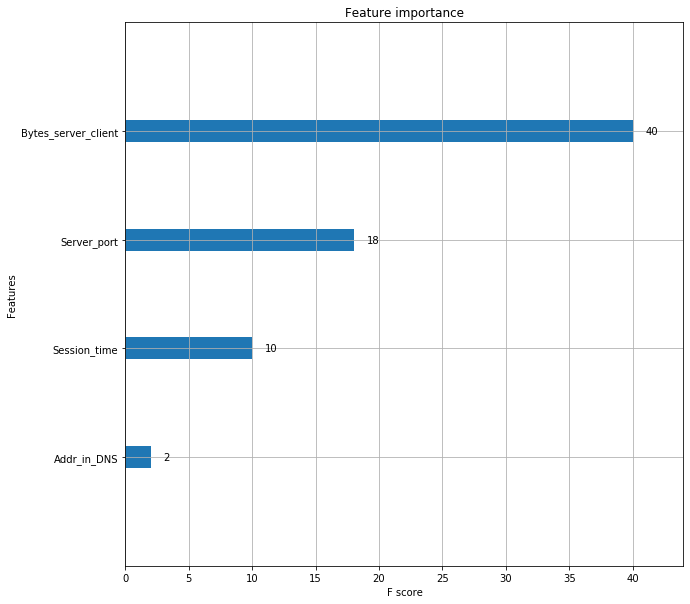

In [48]:
xgboost.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()